Bu Kredi Durum Tahmini veri setinde, daha önce Emlak Kredisi olan mülke göre kredi başvurusunda bulunan başvuru sahiplerinin verileri bulunmaktadır.

 Banka, Başvuru Sahibinin Geliri, Kredi Tutarı, önceki Kredi Geçmişi, Eş Başvuru Sahibinin Geliri gibi bazı faktörlere dayanarak başvuru sahibine kredi verilip verilmeyeceğine karar verecektir.

 Amacımız, başvuru sahibi için kredinin onaylanacağını veya reddedileceğini tahmin etmek için bir Makine Öğrenimi Modeli oluşturmaktır.



Credit_data.csv dosyası hakkında:



 Loan_ID: Benzersiz bir kredi kimliği.

 Cinsiyet: Erkek ya da kadın.

 Evli: Evli (evet) veya Şehit Değil (Hayır).

 Bağımlı Kişiler: Müşteriye bağlı olarak kişi sayısı.

 Eğitim: Adayın Eğitimi (Lisans veya Lisans).

 Self_Employed: Serbest meslek sahibi (Evet/Hayır).

 Başvuru Sahibinin Geliri: Başvuru sahibinin geliri.

 Eş-başvuru sahibinin geliri: Eş-başvuru sahibinin geliri.

 Kredi Tutarı: Bin cinsinden kredi tutarı.

 Loan_Amount_Term: Kredinin ay cinsinden vadesi.

 Credit_History: Kredi geçmişi kurallara uygundur.

 Property_Area: Başvuru sahipleri Kentsel, Yarı Kentsel veya Kırsal yaşıyor.

 Loan_Status: Kredi onaylandı (E/H).

# IMPORT AND DATASET

In [162]:
# Veri yükleme ve işleme
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

# Veri ön işleme
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# KNN algoritması
from sklearn.neighbors import KNeighborsClassifier

# Model değerlendirme
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Uyarıları kapatma
import warnings
warnings.filterwarnings('ignore')


In [163]:
df = pd.read_csv("loan_data.csv")

In [164]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


# EDA

In [165]:
def check_df(dataframe):
  print("----------SHAPE----------")
  print(dataframe.shape)
  print("----------TYPE----------")
  print(dataframe.dtypes)
  print("----------NULL----------")
  print(dataframe.isnull().sum())

In [166]:
check_df(df)

----------SHAPE----------
(381, 13)
----------TYPE----------
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object
----------NULL----------
Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64


In [167]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [168]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 381
Variables: 13
cat_cols: 8
num_cols: 4
cat_but_car: 1
num_but_cat: 1


In [169]:
# kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("------------------------------------")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, color="Black")
        plt.show()

             Loan_Status      Ratio
Loan_Status                        
Y                    271  71.128609
N                    110  28.871391
------------------------------------


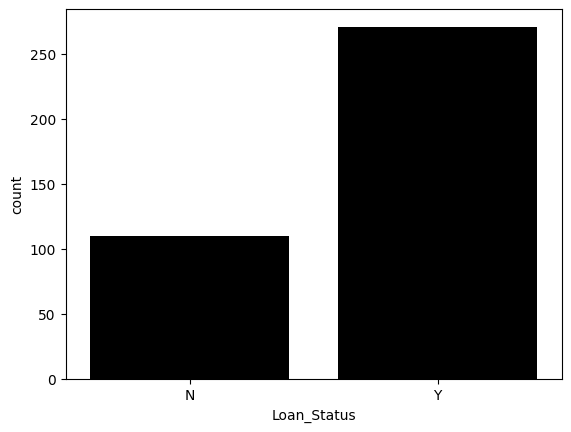

In [170]:
cat_summary(df, "Loan_Status", True)

In [171]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20, color="Red")
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count     381.000000
mean     3579.845144
std      1419.813818
min       150.000000
5%       1836.000000
10%      2060.000000
20%      2483.000000
30%      2750.000000
40%      3074.000000
50%      3333.000000
60%      3620.000000
70%      4000.000000
80%      4583.000000
90%      5488.000000
95%      6250.000000
99%      7916.800000
max      9703.000000
Name: ApplicantIncome, dtype: float64


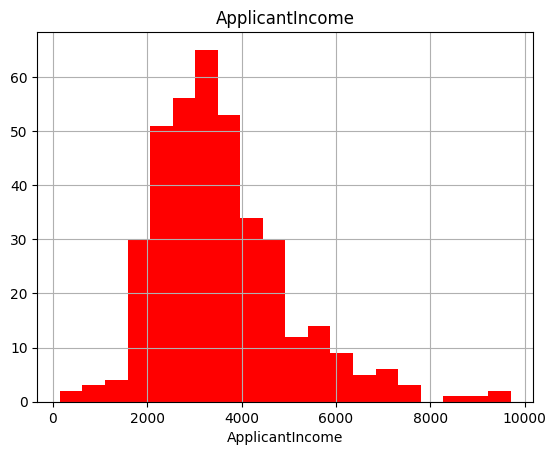

count      381.000000
mean      1277.275381
std       2340.818114
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%        983.000000
60%       1522.000000
70%       1842.000000
80%       2200.000000
90%       2840.000000
95%       3440.000000
99%       5574.800000
max      33837.000000
Name: CoapplicantIncome, dtype: float64


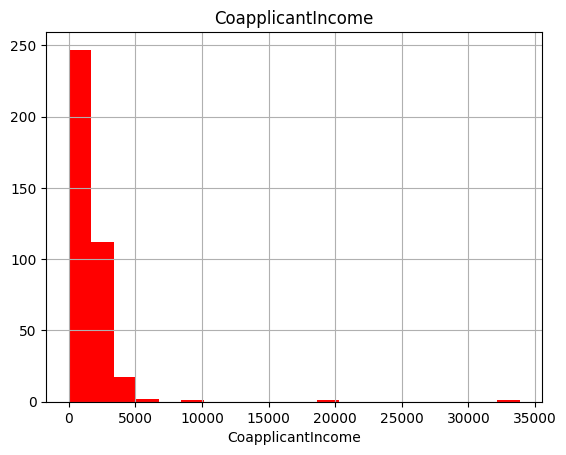

count    381.000000
mean     104.986877
std       28.358464
min        9.000000
5%        50.000000
10%       65.000000
20%       81.000000
30%       95.000000
40%      103.000000
50%      110.000000
60%      116.000000
70%      123.000000
80%      130.000000
90%      137.000000
95%      142.000000
99%      150.000000
max      150.000000
Name: LoanAmount, dtype: float64


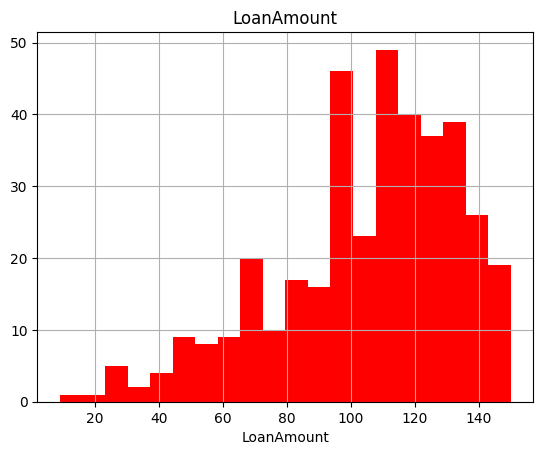

count    370.000000
mean     340.864865
std       68.549257
min       12.000000
5%       180.000000
10%      180.000000
20%      360.000000
30%      360.000000
40%      360.000000
50%      360.000000
60%      360.000000
70%      360.000000
80%      360.000000
90%      360.000000
95%      360.000000
99%      480.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64


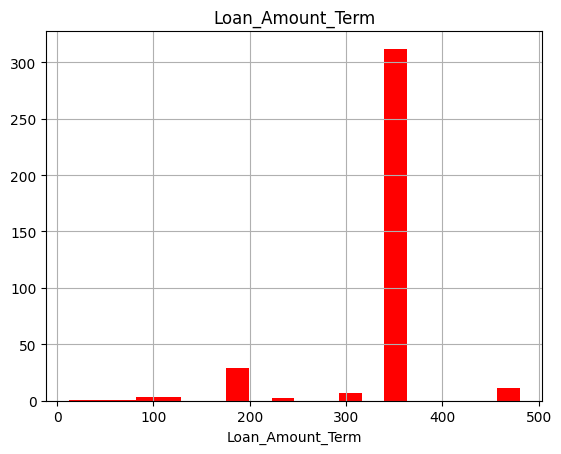

In [172]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [173]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [174]:
for col in num_cols:
    target_summary_with_num(df, "Loan_Status", col)

             ApplicantIncome
Loan_Status                 
N                3602.472727
Y                3570.660517


             CoapplicantIncome
Loan_Status                   
N                  1244.190909
Y                  1290.704502


             LoanAmount
Loan_Status            
N            103.154545
Y            105.730627


             Loan_Amount_Term
Loan_Status                  
N                  346.057143
Y                  338.807547




In [175]:
df[num_cols].corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.248693,0.270681,-0.109875
CoapplicantIncome,-0.248693,1.000000,0.114936,0.001906
LoanAmount,0.270681,0.114936,1.000000,0.123579
Loan_Amount_Term,-0.109875,0.001906,0.123579,1.000000


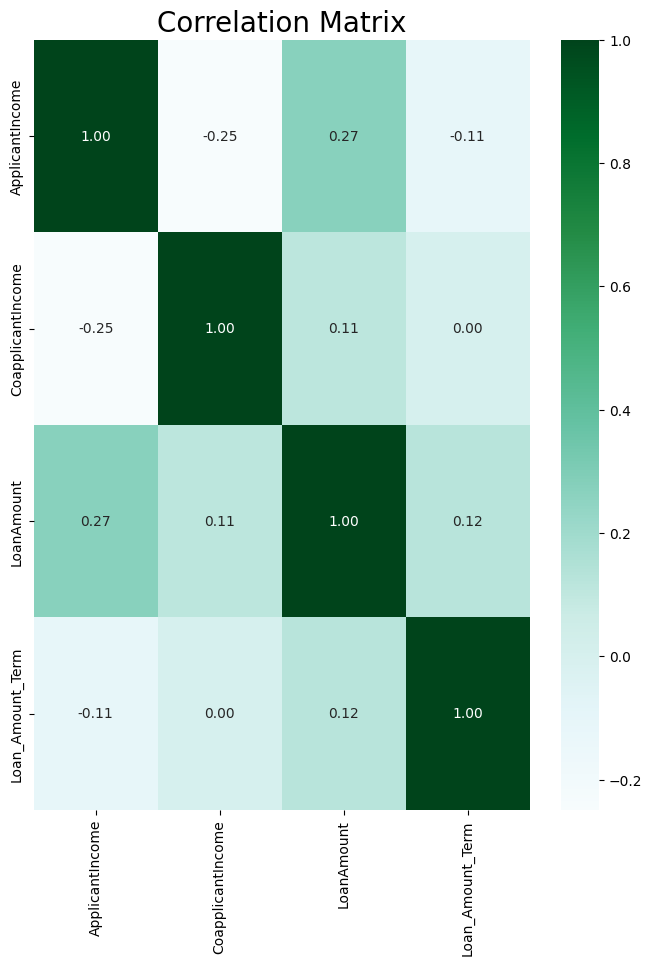

In [176]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[8, 10])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="BuGn")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# FEATURE ENGINEERING

In [177]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [178]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 381
Variables: 13
cat_cols: 8
num_cols: 4
cat_but_car: 1
num_but_cat: 1


In [179]:
def outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95):
  quartile1 = dataframe[variable].quantile(q1)
  quartile3 = dataframe[variable].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

In [180]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [181]:
for col in num_cols:
    if col != "Loan_Status":
      print(col, check_outlier(df, col))

ApplicantIncome False
CoapplicantIncome True
LoanAmount False
Loan_Amount_Term False


In [182]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [183]:
for col in num_cols:
    if col != "Loan_Status":
        replace_with_thresholds(df,col)

In [184]:
for col in num_cols:
    if col != "Loan_Status":
      print(col, check_outlier(df, col))

ApplicantIncome False
CoapplicantIncome False
LoanAmount False
Loan_Amount_Term False


In [185]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [186]:
missing_values_table(df)

                  n_miss  ratio
Credit_History        30   7.87
Self_Employed         21   5.51
Loan_Amount_Term      11   2.89
Dependents             8   2.10
Gender                 5   1.31


In [187]:
cat_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status',
 'Credit_History']

In [188]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="Loan_Status"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)

    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

In [189]:
df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
Gender               5
Dependents           8
Self_Employed       21
Loan_Amount_Term    11
Credit_History      30
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

Gender              0
Dependents          0
Self_Employed       0
Loan_Amount_Term    0
Credit_History      0
dtype: int64 




In [190]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [191]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

In [192]:
df[binary_cols].head(3)

,Gender,Married,Education,Self_Employed,Loan_Status
0,Male,Yes,Graduate,No,N
1,Male,Yes,Graduate,Yes,Y
2,Male,Yes,Not Graduate,No,Y


In [193]:
for col in binary_cols:
  label_encoder(df,col)

In [194]:
df[binary_cols].head(3)

,Gender,Married,Education,Self_Employed,Loan_Status
0,1,1,0,0,0
1,1,1,0,1,1
2,1,1,1,0,1


In [195]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in "Loan_Status"]

In [196]:
cat_cols

['Dependents', 'Property_Area', 'Credit_History']

In [197]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  return dataframe

In [198]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [199]:
df.shape

(381, 16)

In [200]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [201]:
df.head(2)

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban,Credit_History_1.0
0,LP001003,1,1,0,0,0.707469,0.230723,0.812575,0.275147,0,True,False,False,False,False,True
1,LP001005,1,1,0,1,-0.408932,-0.830422,-1.376596,0.275147,1,False,False,False,False,True,True


# MODEL

In [202]:
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df["Loan_Status"]

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [204]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [205]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7478260869565218
Confusion Matrix:
 [[ 8 27]
 [ 2 78]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.23      0.36        35
           1       0.74      0.97      0.84        80

    accuracy                           0.75       115
   macro avg       0.77      0.60      0.60       115
weighted avg       0.76      0.75      0.69       115



In [206]:
# modelimize 5 katlı çapraz doğrulama yaptık başarı tahminimiz için
cv_results = cross_validate(knn_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [207]:
#sonuçlarda roc_auc'da farklı farklı skorlar çıktı
cv_results

{'fit_time': array([0.00592995, 0.00547051, 0.00528765, 0.00553346, 0.00569201]),
 'score_time': array([0.02568936, 0.02479601, 0.02563095, 0.02982569, 0.02522898]),
 'test_accuracy': array([0.76623377, 0.76315789, 0.76315789, 0.77631579, 0.76315789]),
 'test_f1': array([0.85714286, 0.85245902, 0.85      , 0.85470085, 0.85245902]),
 'test_roc_auc': array([0.7338843 , 0.75673401, 0.72643098, 0.78745791, 0.78619529])}

In [208]:
cv_results['test_accuracy'].mean()

0.7664046479835953

In [209]:
cv_results['test_f1'].mean()

0.8533523489261194

In [210]:
cv_results['test_roc_auc'].mean()

0.7581404958677685

In [211]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [212]:
knn_params = {"n_neighbors": range(2, 50)}

In [213]:
knn_gs_best = GridSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, verbose=1).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [214]:
knn_gs_best.best_params_

{'n_neighbors': 6}

# BEST MODEL END

In [215]:
knn_final = knn_model.set_params(**knn_gs_best.best_params_).fit(X, y)

In [216]:
cv_results = cross_validate(knn_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [217]:
cv_results['test_accuracy'].mean()

0.7742993848257006

In [218]:
cv_results['test_f1'].mean()

0.8543883752223079

In [219]:
cv_results['test_roc_auc'].mean()

0.7596617692072238

In [220]:
random_user = X.sample(1)
knn_final.predict(random_user)

array([0])